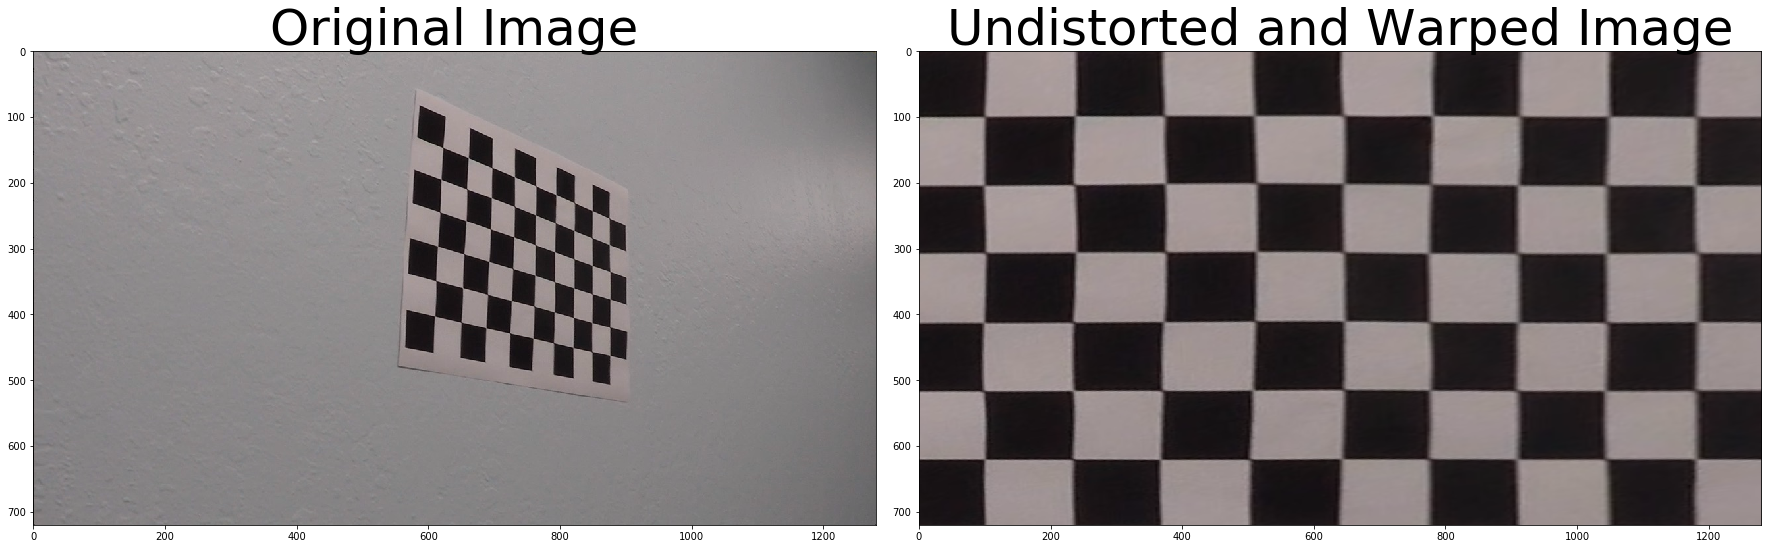

In [36]:
## This de-warps an image starting from a pickled camera matrix, mtx, and the distortion coefficients dist

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration9.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
#     plt.imshow(img)
#     plt.show()
    
#     plt.imshow(undist)
#     plt.show()
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
#     plt.imshow(gray,cmap='gray')
#     plt.show()
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     print(ret)
    
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(gray, (nx, ny), corners, ret)
        
#         plt.imshow(gray,cmap='gray')
#         plt.show()
        
        # b) define 4 source points 
        src = np.float32([corners[0],corners[8],corners[-9],corners[-1]])

        # c) define 4 destination points 
        dst = np.float32([[100,100],[img.shape[1]-100,100],[100,img.shape[0]-100],[img.shape[1]-100,img.shape[0]-100]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src,dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LINEAR) 
        return warped, M

    
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

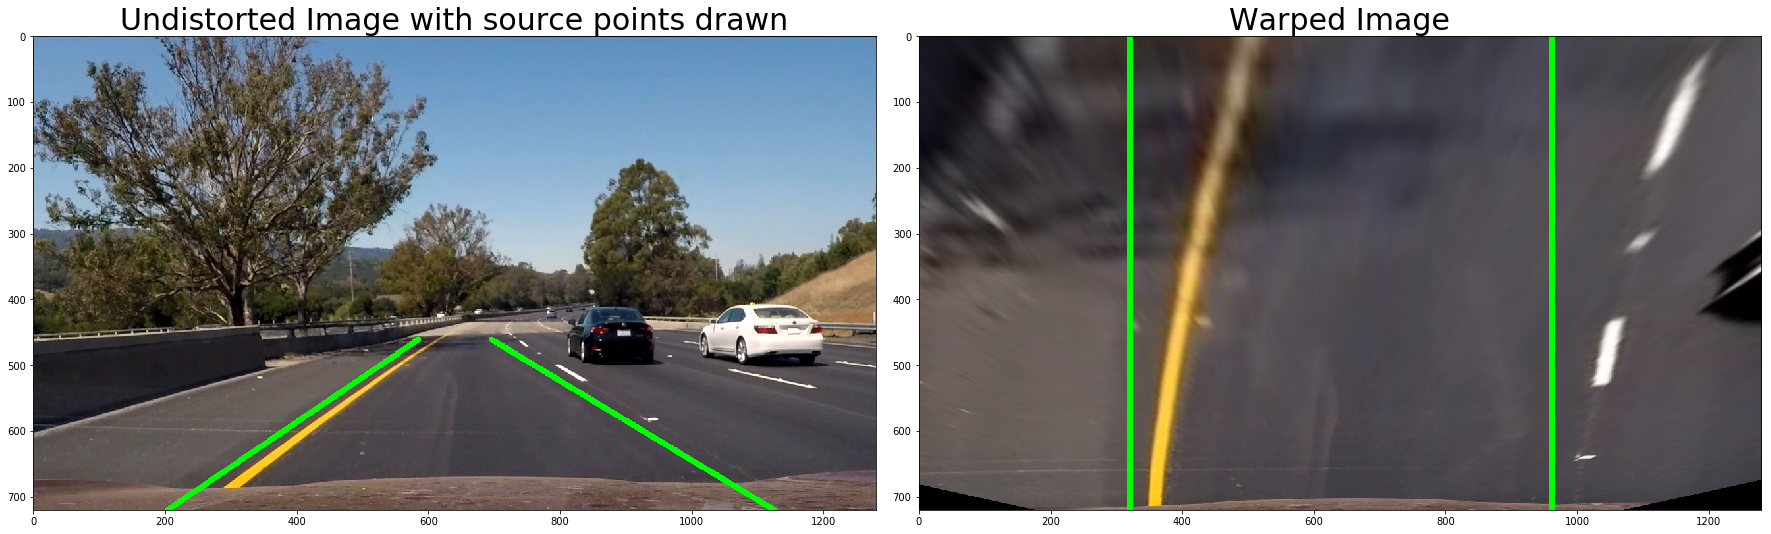

In [40]:

# Now let's do the same (de)warping to a road image
# The instruction advice to assume that the road is a flat plane and thus we can choose our points for the transformation
# directly on an image (possibly coming from the same video we'll analyse)

# a better solution would of course to identify (maybe roughly) the lanes beforehand and select 4 points there ... we'll se

def road_perspective(img, src, dst, mtx, dist):

    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img.shape[1::-1], flags=cv2.INTER_LINEAR) # img.shape[1::-1]cause it's 3 channels now
    
    return warped, M

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if len(lines)>0:
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
# Read in an image
img = mpimg.imread('test_images/test6.jpg')
# img = mpimg.imread('test_images/test.jpg')
# img = mpimg.imread('test_images/straight_lines2.jpg')


# copy the original image
clone_img = img.copy()

# lines = np.array([(240,img.shape[0],603,450),(1220,img.shape[0],688,450)],dtype=np.int)
lines = np.array([
    (240,img.shape[0],597,455),
    (1220,img.shape[0],698,455)],
    dtype=np.int)
# lines = np.array([(240,img.shape[0],590,460),(1220,img.shape[0],710,460)],dtype=np.int)

src = np.float32([np.array([lines[0][:2]]),np.array([lines[0][2:4]]),
                  np.array([lines[1][:2]]),np.array([lines[1][2:4]])])
dst = np.float32([np.array([[325,img.shape[0]]]),np.array([[325,0]]),
                  np.array([[975,img.shape[0]]]),np.array([[975,0]])])

img_size = img.shape
src2 = np.float32(
    [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
    [((img_size[1] / 6) - 10), img_size[0]],
    [(img_size[1] / 2 + 55), img_size[0] / 2 + 100],
    [(img_size[1] * 5 / 6) + 60, img_size[0]]])

dst2 = np.float32(
    [[(img_size[1] / 4), 0],
    [(img_size[1] / 4), img_size[0]],
    [(img_size[1] * 3 / 4), 0],
    [(img_size[1] * 3 / 4), img_size[0]]])

lines2 = np.array([
    ((img_size[1] / 2) - 55, img_size[0] / 2 + 100,(img_size[1] / 6) - 10, img_size[0]),
    ((img_size[1] / 2) + 55, img_size[0] / 2 + 100,(img_size[1] * 5 / 6) + 60, img_size[0] )],
    dtype=np.int)


draw_lines( clone_img , lines2 ,thickness=8, color=(0,255,0))

top_down, perspective_M = road_perspective(img, src2, dst2, mtx, dist)

clone_td = top_down.copy()

draw_lines( clone_td , 
           np.array([
               ((img_size[1] / 4), 0,(img_size[1] / 4), img_size[0]),
               ((img_size[1] * 3 / 4), 0, (img_size[1] * 3 / 4), img_size[0])],
               dtype=np.int),
           thickness=8,color=(0,255,0))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(clone_img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=30)
ax2.imshow(clone_td)
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave(arr=top_down,fname="examples/warped_example.jpg",cmap='gray')